In [1]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
path=Path('data')

In [3]:
path.ls()

[PosixPath('data/Anno'),
 PosixPath('data/export.pkl'),
 PosixPath('data/img'),
 PosixPath('data/models'),
 PosixPath('data/Eval')]

In [4]:
f=open(path/"Anno/list_category_cloth.txt", "r")
contents =f.read().splitlines()

In [5]:
num_classes = int(contents[0])
print(num_classes)

50


In [6]:
classes = []
for i in range(2,len(contents)):
    classes.append(contents[i].split(" ")[0])
print(classes)

['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']


In [7]:
f=open(path/"Anno/list_category_img.txt", "r")
labels_content =f.read().splitlines()

f=open(path/"Eval/list_eval_partition.txt", "r")
val_split =f.read().splitlines()

In [8]:
labels = []
for i in range(2,len(labels_content)):
    labels.append(np.append(labels_content[i].split(),val_split[i].split()[1]))  

In [9]:
labels_df = pd.DataFrame(labels)
labels_df['is_valid'] =  labels_df.apply(lambda row: False if row[2] == "train" else True, axis=1)

In [10]:
labels_df.head()

,0,1,2,is_valid
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,train,False
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,train,False
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,val,True
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,train,False
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,test,True


In [11]:
labels_df.rename(columns = {0:'filename',1:'label', 2:'val_label'}, inplace = True) 

In [12]:
#trained_labels = labels_df.groupby('label').apply(lambda x: x.sample(n=1000, replace=True))
trained_labels = labels_df.sample(n=50000, random_state=1)

In [13]:
trained_labels.head()

,filename,label,val_label,is_valid
131971,img/Raglan_Pocket_Tee/img_00000021.jpg,18,train,False
165076,img/Kaleidoscope_Print_Culottes/img_00000007.jpg,23,test,True
147455,img/Button-Tab_Ankle_Chinos/img_00000031.jpg,22,train,False
220005,img/Elegant_Crochet_Lace_Dress/img_00000011.jpg,41,test,True
242732,img/Leopard_Print_Maxi_Dress/img_00000083.jpg,41,train,False


In [14]:
def get_data(bs=128, size=256):
    src = ImageList.from_df(trained_labels, path)
    src = src.split_from_df(col='is_valid')
    #src = src.split_by_rand_pct(0.2)
    src = src.label_from_df(cols='label')
    src = src.transform(get_transforms(), size=size)
    return src.databunch(path=path, bs=bs).normalize(imagenet_stats)

In [15]:
data = get_data()

In [16]:
#data=ImageDataBunch.from_df(path=path/"", df=labels_df, fn_col='filename', label_col='label', 
    #                       ds_tfms=get_transforms(), size=256, bs=8).normalize(imagenet_stats)

In [17]:
learn=cnn_learner(data, models.resnet50, metrics=[accuracy, top_k_accuracy]).to_fp16()

In [ ]:
#learn.summary()

In [18]:
learn.freeze()

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


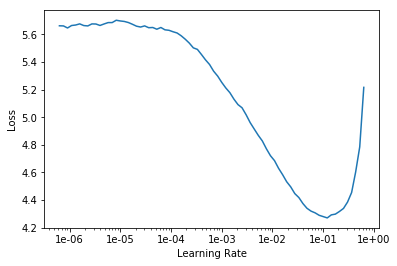

In [20]:
learn.recorder.plot()

In [21]:
lr=5e-3
learn.fit_one_cycle(30, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.551353,1.924404,0.514416,0.827966,03:33
1,2.007290,1.657246,0.546842,0.866994,03:43
2,1.690853,1.457195,0.579415,0.887756,03:43
3,1.524446,1.388613,0.588658,0.898247,03:43
4,1.465927,1.361339,0.601937,0.899347,03:43
5,1.421289,1.340458,0.610373,0.900301,03:43
6,1.390683,1.321361,0.616242,0.901915,03:43
7,1.362126,1.317827,0.609053,0.904409,03:43
8,1.301815,1.277127,0.623945,0.909765,03:43
9,1.296523,1.274508,0.626807,0.909691,03:43


In [22]:
interp=ClassificationInterpretation.from_learner(learn)

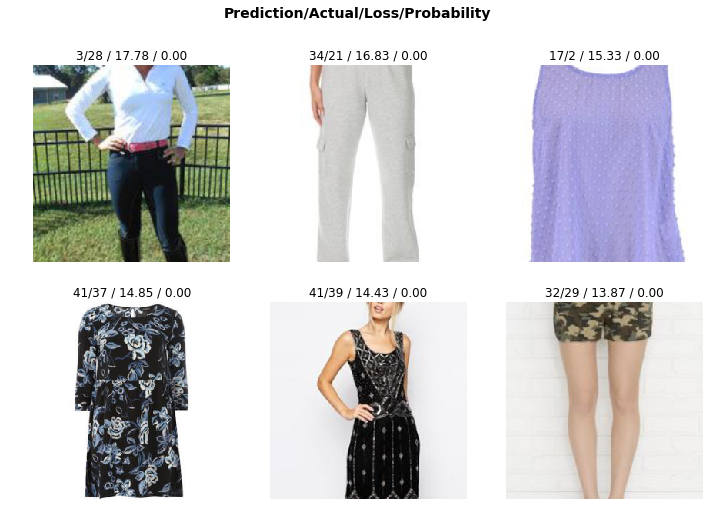

In [23]:
interp.plot_top_losses(k=6, figsize=(12, 8))

In [24]:
learn.save("trained_model_resnet50_30epoch_50k")
learn.export()

## Showing results

In [ ]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = learn.model(x.to('cuda'))

In [ ]:
x.shape, y[0].shape, yhat.shape